In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2.14.0


# **Define datasets path and load the images into TensorFlow Datasets**

In [2]:
train_dir = r'C:\Users\Asus\IE4483\IE4483datasets\datasets\train'
val_dir   = r'C:\Users\Asus\IE4483\IE4483datasets\datasets\val'
test_dir  = r'C:\Users\Asus\IE4483\IE4483datasets\datasets\test'

# Load images from directory for training/validation
img_size = (64, 64)  # or (224, 224) depending on your model
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    # Use decode_image to support png/jpg; expand_animations False avoids 4-D for gifs
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Normalize pixel values for train/val (they come as (x, y) pairs)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds   = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds  = test_ds.map(lambda x, y: (x / 255.0, y))


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [3]:
for images, labels in train_ds.take(1):
    print(images.shape)  # e.g. (32, 32, 32, 3)
    print(labels.shape)  # e.g. (32, 10)

(16, 64, 64, 3)
(16,)


In [4]:
def prepare(ds):
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare(train_ds)
val_ds   = prepare(val_ds)
test_ds  = prepare(test_ds)

# **Convolutional Neural Network (CNN) Model — TensorFlow / Keras**
This script defines a Convolutional Neural Network (CNN) using TensorFlow’s Keras API.
It performs image classification with two output classes.

In [5]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.BatchNormalization(input_shape=(img_size[0], img_size[1], 3)),

    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 64, 64, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                        

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# ** Model Compilation and Training — TensorFlow / Keras**
This section defines the optimizer, loss function, metrics, and training procedure for the CNN model.

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
1250/1250 [==============================] - 56s 44ms/step - loss: 0.8762 - accuracy: 0.6245 - val_loss: 0.7638 - val_accuracy: 0.6580
Epoch 2/20
1250/1250 [==============================] - 29s 23ms/step - loss: 0.7126 - accuracy: 0.6889 - val_loss: 0.7026 - val_accuracy: 0.6924
Epoch 3/20
1250/1250 [==============================] - 31s 24ms/step - loss: 0.6596 - accuracy: 0.7256 - val_loss: 0.6760 - val_accuracy: 0.7218
Epoch 4/20
1250/1250 [==============================] - 31s 25ms/step - loss: 0.6302 - accuracy: 0.7440 - val_loss: 0.6316 - val_accuracy: 0.7474
Epoch 5/20
1250/1250 [==============================] - 31s 25ms/step - loss: 0.6016 - accuracy: 0.7570 - val_loss: 0.6144 - val_accuracy: 0.7598
Epoch 6/20
1250/1250 [==============================] - 30s 24ms/step - loss: 0.5885 - accuracy: 0.7645 - val_loss: 0.5822 - val_accuracy: 0.7686
Epoch 7/20
1250/1250 [==============================] - 29s 23ms/step - loss: 0.5679 - accuracy: 0.7730 - val_loss: 0.5710 -

# **Results Visualization**

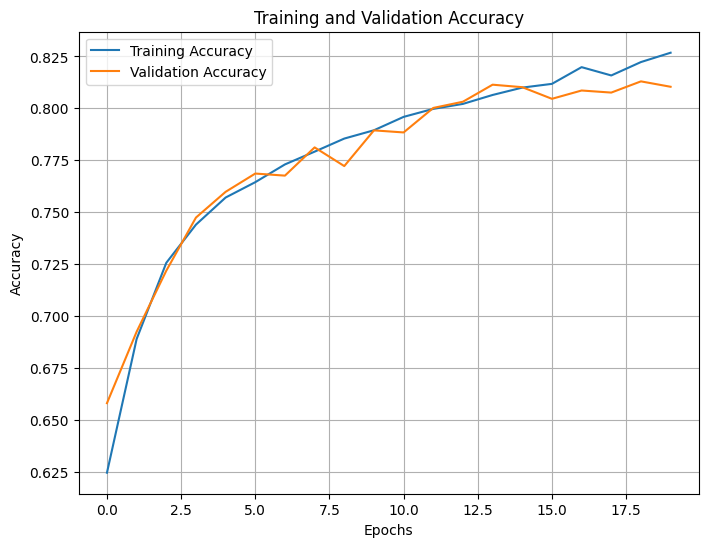

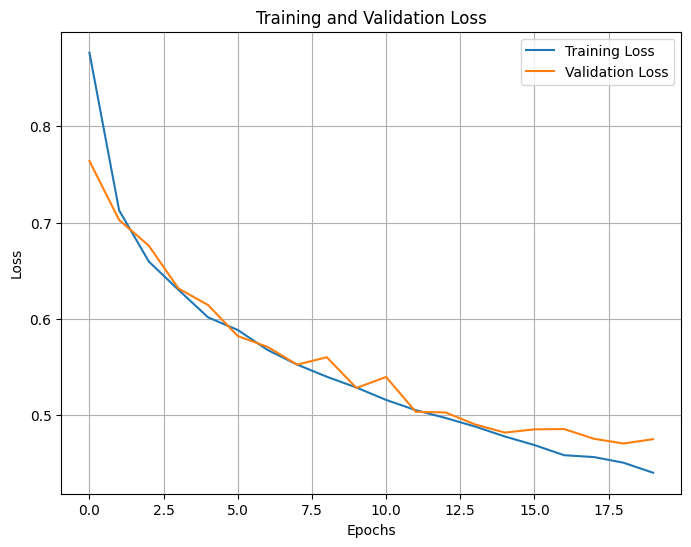

In [8]:
# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Evaluating on test dataset...
32/32 [==============================] - 0s 5ms/step
Found 500 files belonging to 2 classes.

✅ Test Accuracy: 0.8140

=== Classification Report ===
              precision    recall  f1-score   support

         cat       0.81      0.80      0.81       241
         dog       0.81      0.83      0.82       259

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



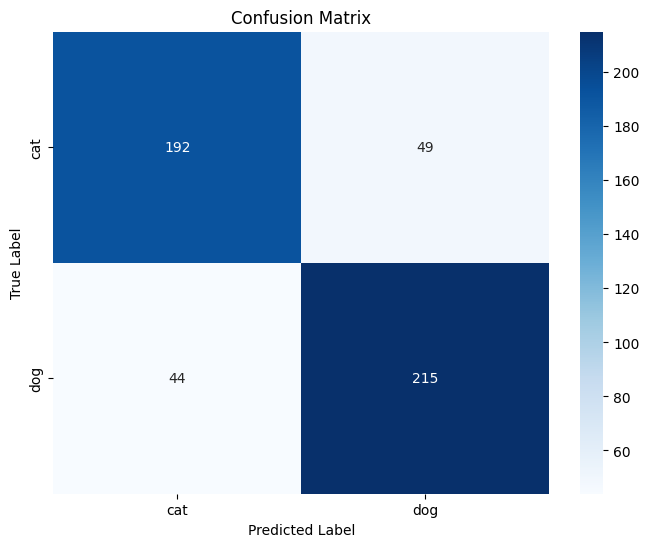

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Evaluate model ===
print("\nEvaluating on test dataset...")
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# === Class names ===
class_names = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
).class_names

# === Accuracy ===
accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

✅ Loaded CSV with 500 entries
Loaded 500 images from C:\Users\Asus\IE4483\IE4483datasets\datasets\test_unclassified
16/16 [==============================] - 0s 9ms/step

✅ Test Accuracy: 0.8200

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       242
           1       0.82      0.84      0.83       258

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



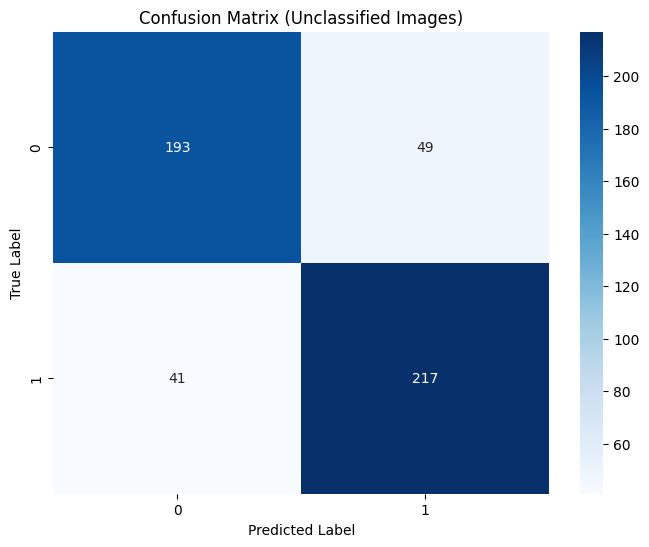


📁 Predictions saved to: C:\Users\Asus\IE4483\IE4483datasets\datasets\CNNpredicted_labels.csv


In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === Paths ===
csv_path = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\testClassification.csv"
img_dir = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\test_unclassified"
output_csv = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\CNNpredicted_labels.csv"

# === Load CSV (no header) ===
df = pd.read_csv(csv_path, header=None, names=["filename", "label"])
print("✅ Loaded CSV with", len(df), "entries")

# === Load and preprocess images ===
img_size = (64, 64)  # same as during training
images = []
true_labels = []
filenames = []  

for _, row in df.iterrows():
    fname = str(row["filename"])      # use fname to avoid name conflict
    label = int(row["label"])
    img_path = os.path.join(img_dir, f"{fname}.jpg")  # adjust extension if needed
    if not os.path.exists(img_path):
        print(f"⚠️ Missing file: {img_path}")
        continue

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    images.append(img_array)
    true_labels.append(label)
    filenames.append(fname)  # <-- collect filename here

images = np.array(images)
true_labels = np.array(true_labels)

print(f"Loaded {len(images)} images from {img_dir}")

# === Predict ===
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# === Accuracy ===
accuracy = np.mean(predicted_classes == true_labels)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_classes))

# === Confusion Matrix ===
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Unclassified Images)')
plt.show()

# === Save predictions to CSV ===
results_df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "predicted_label": predicted_classes
})
results_df.to_csv(output_csv, index=False)
print(f"\n📁 Predictions saved to: {output_csv}")
